In [1]:
import numpy as np
import matplotlib.pyplot as plt
from poke.thinfilms import compute_thin_films_broadcasted
from poke.polarization import fresnel_coefficients
from poke.materials import create_index_model

In [2]:
def high_reflector_d(nf,ns,wl,aoi):
    """thickness of a low-index film deposited on a dielectric layer to maximize reflectance

    'This is the thickness that the low-index layer next to the metal should have if the 
    maximum possible increase in reflectance is to be achieved ... Layers other than that
    next to the metal will, of course, retain their quarter-wave thicknesses. Usually, however,
    the layer is simply made a quarter wave because the resulting difference in performance over
    the visible region is not great'
    - Macleod 1969 s5.1.3

    Parameters
    ----------
    nf : float
        thin film index
    ns : float
        substrate index
    wl : float
        design wavelength
    aoi : float
        angle of incidence

    Returns
    -------
    _type_
        _description_
    """

    a = np.real(ns)
    b = np.imag(ns)
    eta_f = nf * np.cos(aoi) # s pol

    atan_num = 2 * b * eta_f
    atan_den = (eta_f**2 - a**2 - b**2)
    atan = np.arctan(atan_num / atan_den)
    lam_scale = wl / (4 * np.pi)

    return -np.real(atan * lam_scale)

def quarter_wave_optical_thickness(n, wvl):
    return wvl / (4 * n)

def R_from_fresnel(rs,rp):
    return (np.abs(rs)**2 + np.abs(rp)**2) / 2

def A_from_fresnel(rs,rp):
    return np.angle(rs) - np.angle(rp)

# Build up a stack
wl = np.arange(0.4,1.8,0.001) # halpha ish
aoi = np.full_like(wl,np.radians(60))

# try and generate some index models
n_Ag = create_index_model('Ag')
n_HfO2 = create_index_model('HfO2')
n_SiO2 = create_index_model('SiO2')
n_MgF2 = create_index_model('MgF2')
n_Ta2O5 = create_index_model('Ta2O5')
n_Nb2O5 = create_index_model('Nb2O5')

In [13]:
# Try a simple silver layer
rs,rp = fresnel_coefficients(aoi,1,n_Ag(wl),mode='reflect')
R_bare_Ag = R_from_fresnel(rs,rp)
A_bare_Ag = A_from_fresnel(rs,rp)

# get the film thickness
wl_ref = 1 # um
d_film_Si = quarter_wave_optical_thickness(n_SiO2(wl_ref), wl_ref)
d_film_Mg = quarter_wave_optical_thickness(n_MgF2(wl_ref), wl_ref)
d_film_Ta = quarter_wave_optical_thickness(n_Ta2O5(wl_ref), wl_ref)
d_film_Nb = quarter_wave_optical_thickness(n_Nb2O5(wl_ref), wl_ref)

t_film_Si = high_reflector_d(n_SiO2(wl_ref),n_Ag(wl_ref),wl_ref,aoi)
t_film_Mg = high_reflector_d(n_MgF2(wl_ref),n_Ag(wl_ref),wl_ref,aoi)

# create a stack
stack_TaSi = [
    (n_Ta2O5(wl),np.full_like(wl,d_film_Ta)),
    (n_SiO2(wl),np.full_like(wl,d_film_Si)),
    (n_Ta2O5(wl),np.full_like(wl,d_film_Ta)),
    (n_SiO2(wl),np.full_like(wl,t_film_Si)),
    (n_Ag(wl))
]

stack_NbSi = [
    (n_Nb2O5(wl),np.full_like(wl,d_film_Nb)),
    (n_SiO2(wl),np.full_like(wl,d_film_Si)),
    (n_Nb2O5(wl),np.full_like(wl,d_film_Nb)),
    (n_SiO2(wl),np.full_like(wl,t_film_Si)),
    (n_Ag(wl))
]

stack_TaMg = [
    (n_Ta2O5(wl),np.full_like(wl,d_film_Ta)),
    (n_MgF2(wl),np.full_like(wl,d_film_Mg)),
    (n_Ta2O5(wl),np.full_like(wl,d_film_Ta)),
    (n_MgF2(wl),np.full_like(wl,t_film_Mg)),
    (n_Ag(wl))
]

stack_NbMg = [
    (n_Nb2O5(wl),np.full_like(wl,d_film_Nb)),
    (n_MgF2(wl),np.full_like(wl,d_film_Mg)),
    (n_Nb2O5(wl),np.full_like(wl,d_film_Nb)),
    (n_MgF2(wl),np.full_like(wl,t_film_Mg)),
    (n_Ag(wl))
]

rs,_ = compute_thin_films_broadcasted(stack_TaSi,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_TaSi,aoi,wl,substrate_index=n_Ag(wl),polarization='p')
R_coated_TaSi = R_from_fresnel(rs,rp)

rs,_ = compute_thin_films_broadcasted(stack_NbSi,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_NbSi,aoi,wl,substrate_index=n_Ag(wl),polarization='p')
R_coated_NbSi = R_from_fresnel(rs,rp)

rs,_ = compute_thin_films_broadcasted(stack_TaMg,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_TaMg,aoi,wl,substrate_index=n_Ag(wl),polarization='p')
R_coated_TaMg = R_from_fresnel(rs,rp)

rs,_ = compute_thin_films_broadcasted(stack_NbMg,aoi,wl,substrate_index=n_Ag(wl),polarization='s')
rp,_ = compute_thin_films_broadcasted(stack_NbMg,aoi,wl,substrate_index=n_Ag(wl),polarization='p')
R_coated_NbMg = R_from_fresnel(rs,rp)

<__array_function__ internals>:200: ComplexWarning: Casting complex values to real discards the imaginary part


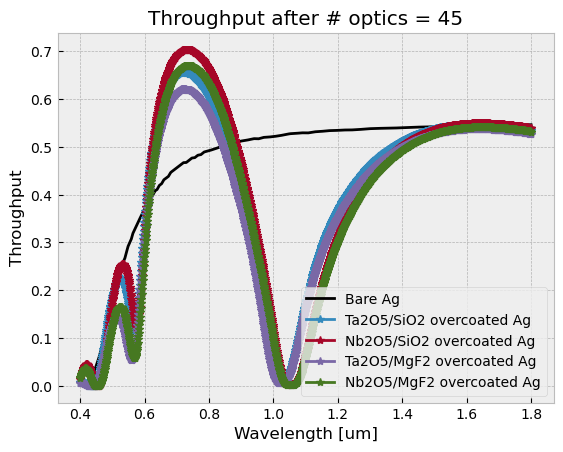

In [14]:
plt.style.use('bmh')
noptics = 45

plt.figure()
plt.title(f'Throughput after # optics = {noptics}')
plt.plot(wl,R_bare_Ag**noptics,label='Bare Ag',color='black')
plt.plot(wl,R_coated_TaSi**noptics,label='Ta2O5/SiO2 overcoated Ag',marker='*')
plt.plot(wl,R_coated_NbSi**noptics,label='Nb2O5/SiO2 overcoated Ag',marker='*')
plt.plot(wl,R_coated_TaMg**noptics,label='Ta2O5/MgF2 overcoated Ag',marker='*')
plt.plot(wl,R_coated_NbMg**noptics,label='Nb2O5/MgF2 overcoated Ag',marker='*')
# plt.plot(wl,R_coated_Ta**noptics,label='Ta overcoated Ag',marker='o')
# plt.plot(wl,R_coated_Nb**noptics,label='Nb overcoated Ag',marker='.')
plt.ylabel('Throughput')
plt.xlabel('Wavelength [um]')
plt.legend()